In [1]:
import pandas as pd, torch, torch.nn as nn, pickle
from sklearn.model_selection import train_test_split
import glob, os, timeit
import torch.nn.functional as F
import numpy as np

In [2]:
torch.cuda.is_available()

True

In [3]:
fulldf = pd.read_csv('accessibilty-percents-10000-bin.csv', index_col=0, chunksize=20)

chunks = list()

for idx, chunk in enumerate(fulldf):
  #if idx > 4:
  #  break
  print(idx)
  chunks.append(chunk)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [14]:
all_data = pd.concat(chunks)
all_data

NameError: name 'chunks' is not defined

In [15]:
# In the first step we will split the data in training and remaining dataset
data_train, data_rem = train_test_split(all_data, train_size=0.8, random_state=543)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
data_validation, data_test = train_test_split(data_rem, test_size=0.5, random_state=82)

print(type(data_train))
print(data_train.shape)
print(data_validation.shape)
print(data_test.shape)

<class 'pandas.core.frame.DataFrame'>
(361, 82)
(45, 82)
(46, 82)


# PCA Transformed Dataset

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Note not using scaling here just because everything should fall into the range of 0-1 because we're looking at accessibility % in a bin.
# I suppose to be safe I could scale but it seems the impact would be small

pca = PCA(n_components=50)
data_train.iloc[:, 5:].shape
pca.fit(data_train.iloc[:, 5:])
#print(data_train.shape)
#data_train.iloc[:, 5:]

PCA(n_components=50)

In [7]:
abs(pca.components_[0])

most_impactful_100 = list()

for i in range(10):
  ind = np.argpartition(pca.components_[i], -10)[-10:]
  ind.sort()
  print(ind)
  most_impactful_100.extend(ind)

len(set(most_impactful_100))

list.sort(most_impactful_100)

from collections import Counter
asdf = Counter(most_impactful_100)

# These bins in the genome end up being top 10 contributions to one of the top 10 PCs more than once - probably means they are influential?
{k: c for k, c in asdf.items() if c > 1}

[ 33697  68767 108413 129054 129687 212738 219772 230563 240958 250791]
[  8226  31591  40059  65193  99532 123912 175753 272922 282195 285943]
[ 34758  48943  79956  87799  88273  92082  96110 181434 240958 288802]
[ 33689  48195  68767 129054 129687 133356 219771 219772 230563 240958]
[ 11728  18485  34495  44083  46313  78999  83720 106304 165661 196354]
[ 33697  68766  68767 129054 129687 139178 219770 219771 219772 240958]
[ 25047 123314 219770 247738 250156 257965 258421 265852 266280 287619]
[  2795  98843 152380 200028 219772 253439 260129 280981 305866 305879]
[ 16141  16143  79921 125955 139474 139538 194208 219770 269320 274160]
[ 24728  88188 129054 129687 219771 219772 230563 233011 240958 303774]


{33697: 2,
 68767: 3,
 129054: 4,
 129687: 4,
 219770: 3,
 219771: 3,
 219772: 5,
 230563: 3,
 240958: 5}

In [8]:
data_train_new = pca.transform(data_train.iloc[:, 5:])
data_test_new = pca.transform(data_test.iloc[:, 5:])
data_validation_new = pca.transform(data_validation.iloc[:, 5:])
pd.DataFrame(data_train_new).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-3.823169,-0.442234,-0.352466,-0.125646,-0.942058,0.081845,0.002106,-0.754735,-0.654548,0.309686,...,-0.276915,0.047358,0.409888,-0.065647,-0.207459,0.053962,-0.074439,-0.229734,0.195143,-0.280579
1,13.768762,9.342824,9.265922,-2.162150,-0.285419,3.360542,-1.121748,-1.407516,-1.136637,-0.051437,...,-0.559655,0.772795,0.374340,3.522630,0.172970,0.551384,-1.341446,0.332488,-0.491526,-0.383272
2,8.298014,4.961191,-2.166806,0.339002,-2.419396,-0.600912,1.823100,2.307296,7.089132,5.641197,...,0.341280,-0.155385,-0.152077,0.121544,-0.028241,-0.017550,0.048439,0.045961,0.056645,0.030743
3,-0.313594,0.749567,-1.764320,-1.976134,-0.091042,-2.370227,0.570475,-0.984619,-0.648931,0.199168,...,-0.142800,-0.100241,-0.087202,-0.027632,0.045658,0.036964,-0.205558,-0.141604,0.185358,-0.022508
4,-5.171958,0.118475,0.574160,-0.049282,0.622066,-0.997077,-0.198883,-0.190330,0.067242,0.119517,...,0.156385,0.094308,0.017669,0.037794,-0.216372,-0.128565,-0.151205,-0.100478,0.042553,0.243491


In [9]:
def convert_back_to_df(data, new_data):
  return pd.concat([data.iloc[:, :5], pd.DataFrame(new_data, index=data.index)], axis=1)

data_train_pca = convert_back_to_df(data_train, data_train_new)
data_test_pca = convert_back_to_df(data_test, data_test_new)
data_validation_pca = convert_back_to_df(data_validation, data_validation_new)

In [10]:
# for chip-seq data: also shuffling nucleotides can be done to keep the GC content the same as positive example
# because sequencing has biases with GC content and this would be a way to "fix it"
class BedPeaksDataset(torch.utils.data.IterableDataset):

    def __init__(self, data_set):
        super(BedPeaksDataset, self).__init__()
        self.atac_data = data_set

    def __iter__(self): 
        for i,row in enumerate(self.atac_data.itertuples()):
            #seq = row.sequence
            value = np.float32(1)
            #print(row)
            #if row._3 == "Normal":
            #print(row[4])
            if row[4] == 'Normal':
                value = np.float32(0)
            #yield(one_hot(seq), value) # positive example
            #x = x[:, :, None]
            yield(torch.FloatTensor(row[6:])[:, None], value)

train_dataset = BedPeaksDataset(data_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, num_workers = 0)

#validation_dataset = BedPeaksDataset(data_validation)
#validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000, num_workers=0)

#test_dataset = BedPeaksDataset(data_test)
#test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, num_workers=0)

data_train

,Biosample type,Biosample name,Tissue type,Cancer type,Region number,0,1,2,3,4,...,309558,309559,309560,309561,309562,309563,309564,309565,309566,309567
Sample_0243,Other,Bulk_B,Blood,Normal,15623,0.0,0.0464,0.0323,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0540,0.0
Sample_0893,Cell Line,Jurkat,Blood,Leukemia,82176,0.0,0.0464,0.2302,0.1406,0.0,...,0.0,0.0,0.0999,0.0,0.0,0.2165,0.0330,0.0927,0.0558,0.0
Sample_0544,Cell Line,U937,Blood,Leukemia,55734,0.0,0.0458,0.2665,0.0401,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0415,0.0420,0.0570,0.0
Sample_1171,Primary Cell,CD19+ B cell,Blood,Normal,39175,0.0,0.0956,0.0416,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0387,0.0
Sample_0832,Primary Cell,YF,Blood,The Yellow fever,10649,0.0,0.0433,0.0300,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0387,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_1255,Primary Cell,CD4+ T cell,Blood,Normal,11895,0.0,0.0452,0.0244,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0540,0.0
Sample_0302,Other,Memory_Teffs,Blood,Normal,52511,0.0,0.0464,0.1069,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0302,0.0547,0.0
Sample_0219,Other,Memory_Teffs,Blood,Normal,39295,0.0,0.1390,0.1210,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0315,0.0000,0.0257,0.0596,0.0
Sample_0273,Other,Th17,Blood,Normal,21152,0.0,0.0463,0.0356,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0585,0.0


In [13]:
def run_one_epoch(train_flag, dataloader, model, optimizer, device="cuda"):

    #print('starting epoch')

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval() 

    losses = []
    accuracies = []

    for (x,y) in dataloader: # collection of tuples with iterator

        (x, y) = ( x.to(device), y.to(device) ) # transfer data to GPU

        output = model(x) # forward pass
        output = output.squeeze(1) # remove spurious channel dimension
        loss = F.binary_cross_entropy_with_logits( output, y ) # numerically stable

        if train_flag: 
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        accuracy = torch.mean( ( (output > .5) == (y > .5) ).float() )
        accuracies.append(accuracy.detach().cpu().numpy())
        #print(losses[-1], accuracies[-1])
    
    return( np.mean(losses), np.mean(accuracies) )

In [14]:
def train_model(model, train_data, validation_data, epochs=100, patience=10, batch_size=1000, verbose = True):
    """
    Train a 1D CNN model and record accuracy metrics.
    """
    # Move the model to the GPU here to make it runs there, and set "device" as above
    # TODO CODE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 1. Make new BedPeakDataset and DataLoader objects for both training and validation data.
    # TODO CODE
    train_dataset = BedPeaksDataset(train_data)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    validation_dataset = BedPeaksDataset(validation_data)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)

    # 2. Instantiates an optimizer for the model. 
    # TODO CODE
    optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

    # 3. Run the training loop with early stopping. 
    # TODO CODE
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    patience_counter = patience
    best_val_loss = np.inf
    
    try:
      os.mkdir('./checkpoints')
    except  FileExistsError:
      pass
    
    # Get a list of all the file paths that ends with .txt from in specified directory
    fileList = glob.glob('./checkpoints/model_checkpoint*.pt')
    # Iterate over the list of filepaths & remove each file.
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)
    
    
    check_point_filename = './checkpoints/model_checkpoint.pt' # to save the best model fit to date
    local_min_counter = 0
    for epoch in range(epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc = run_one_epoch(True, train_dataloader, model, optimizer, device)
        val_loss, val_acc = run_one_epoch(False, validation_dataloader, model, optimizer, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if val_loss < best_val_loss: 
            if patience_counter < patience:
                local_min_counter = local_min_counter + 1
            torch.save(model.state_dict(), f'./checkpoints/model_checkpoint-{local_min_counter}.pt')
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                model.load_state_dict(torch.load(f'./checkpoints/model_checkpoint-{local_min_counter}.pt')) # recover the best model so far
                break
        elapsed = float(timeit.default_timer() - start_time)
        print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" % 
              (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))

    # 4. Return the fitted model (not strictly necessary since this happens "in place"), train and validation accuracies.
    # TODO CODE
    return model, train_accs, val_accs, train_losses, val_losses, validation_dataloader

In [11]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn import metrics

'\nX = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])\n# y = 1 * x_0 + 2 * x_1 + 3\ny = np.dot(X, np.array([1, 2])) + 3\nreg = LinearRegression().fit(X, y)\nreg.score(X, y)\n\nreg.coef_\n\nreg.intercept_\n\nreg.predict(np.array([[3, 5]]))\n'

In [11]:
(data_train['Cancer type'] != 'Normal').astype(float)

Sample_0243    0.0
Sample_0893    1.0
Sample_0544    1.0
Sample_1171    0.0
Sample_0832    1.0
              ... 
Sample_1255    0.0
Sample_0302    0.0
Sample_0219    0.0
Sample_0273    0.0
Sample_0825    1.0
Name: Cancer type, Length: 361, dtype: float64

In [12]:
def shanko_metrics(cm, acc):
  cm = pd.DataFrame(cm, index=['Healthy', 'Disease'], columns=['Healthy', 'Disease'])

  import matplotlib.pyplot as plt
  import seaborn as sns

  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(acc)
  plt.title(all_sample_title, size = 15);

0.9111111111111111


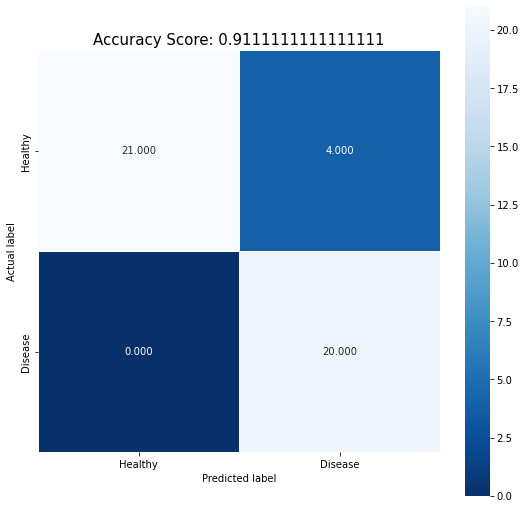

In [13]:
reg = LinearRegression().fit(data_train_new, (data_train['Cancer type'] != 'Normal').astype(float))

val_preds = reg.predict(data_validation_new)
#print(val_preds)
#print((data_validation['Cancer type'] != 'Normal').astype(float))

threshold = .25
total = len(val_preds)
correct = 0
for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
  #print(a, b)
  option1 = (a < threshold) and (b == 0)
  option2 = (a >= threshold) and (b == 1)
  #print(option1 or option2)
  if option1 or option2:
    correct += 1


print(correct / total)


nvp = val_preds >= threshold
cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), nvp)

shanko_metrics(cm, correct/total)

0.9333333333333333
(1, 26)
0.9333333333333333
[1, 26, (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (6, 26), (6, 27), (6, 28), (6, 29), (6, 30), (7, 26), (7, 27), (7, 28), (7, 29), (7, 30), (8, 26), (8, 27), (8, 28), (8, 29), (8, 30), (9, 26), (9, 27), (9, 28), (9, 29), (9, 30), (10, 26), (10, 27), (10, 28), (10, 29), (10, 30), (11, 26), (11, 27), (11, 28), (11, 29), (11, 30), (12, 26), (12, 27), (12, 28), (12, 29), (12, 30), (13, 26), (13, 27), (13, 28), (13, 29), (13, 30), (14, 26), (14, 27), (14, 28), (14, 29), (15, 26), (15, 27), (15, 28), (15, 29), (16, 26), (16, 27), (16, 28), (16, 29), (17, 26), (17, 27), (17, 28), (17, 29), (18, 26), (18, 27), (18, 28), (18, 29), (19, 26), (19, 27), (19, 28), (19, 29), (20, 26), (20, 27), (20, 28), (20, 29), (21, 26), (21, 27), (21, 28), (21, 29), (22, 26), (22, 27), (

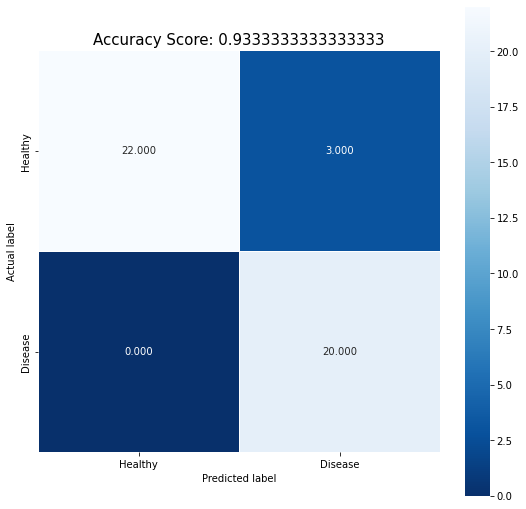

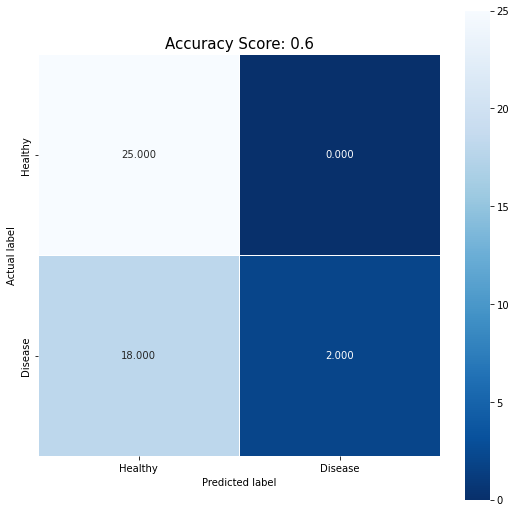

In [82]:
ridge = Ridge(alpha=1).fit(data_train_new, (data_train['Cancer type'] != 'Normal').astype(float))

val_preds = ridge.predict(data_validation_new)

threshold = .27 #different thresholds tested to see which work best
total = len(val_preds)
correct = 0
for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
  #print(a, b)
  option1 = (a < threshold) and (b == 0)
  option2 = (a >= threshold) and (b == 1)
  #print(option1 or option2)
  if option1 or option2:
    correct += 1


print(correct / total)


nvp = val_preds >= threshold
cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), nvp)

shanko_metrics(cm, correct/total)
best_params = {}
max_performance =0
best_param = (1,1)
equivalent_params=[]
for al in range(1,100):
    for t in range(1,100):
        ridge = Ridge(alpha=al/100).fit(data_train_new, (data_train['Cancer type'] != 'Normal').astype(float))

        val_preds = ridge.predict(data_validation_new)

        threshold = t/100 #different thresholds tested to see which work best
        total = len(val_preds)
        correct = 0
        for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
          #print(a, b)
          option1 = (a < threshold) and (b == 0)
          option2 = (a >= threshold) and (b == 1)
          #print(option1 or option2)
          if option1 or option2:
            correct += 1


        #print(correct / total)
        best_params["%d,%d"%(al,t)] = correct / total
        if(correct/total>max_performance):
            best_param=(al,t)
            max_performance=correct/total
            equivalent_params = [al,t]
            
        if(correct/total==max_performance):
            equivalent_params.append((al,t))
        

print(best_param)
print(max_performance)
print(equivalent_params)
nvp = val_preds >= threshold
cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), nvp)

shanko_metrics(cm, correct/total)

Best params are alpha=1, threshold = 0.26 for Ridge

(1, 36)
0.8888888888888888
[1, 36, (1, 36), (1, 37), (1, 38), (1, 41)]


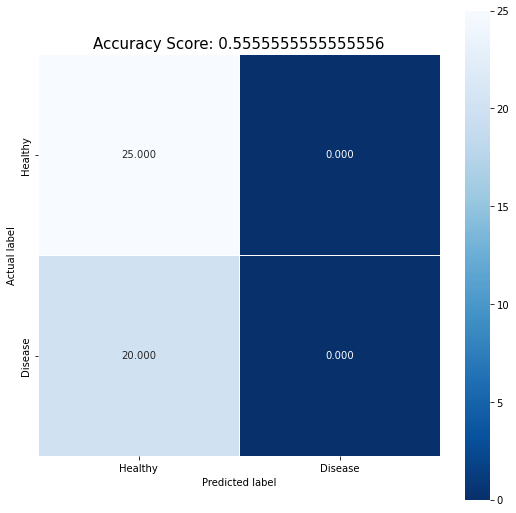

In [16]:
best_params = {}
max_performance =0
best_param = (1,1)
equivalent_params=[]
for al in range(1,100):
    for t in range(1,100):
        lasso = Lasso(alpha=al/100).fit(data_train_new, (data_train['Cancer type'] != 'Normal').astype(float))

        val_preds = lasso.predict(data_validation_new)

        threshold = t/100 #different thresholds tested to see which work best
        total = len(val_preds)
        correct = 0
        for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
          #print(a, b)
          option1 = (a < threshold) and (b == 0)
          option2 = (a >= threshold) and (b == 1)
          #print(option1 or option2)
          if option1 or option2:
            correct += 1


        #print(correct / total)
        best_params["%d,%d"%(al,t)] = correct / total
        if(correct/total>max_performance):
            best_param=(al,t)
            max_performance=correct/total
            equivalent_params = [al,t]
            
        if(correct/total==max_performance):
            equivalent_params.append((al,t))
        

print(best_param)
print(max_performance)
print(equivalent_params)
nvp = val_preds >= threshold
cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), nvp)

shanko_metrics(cm, correct/total)

0.8888888888888888


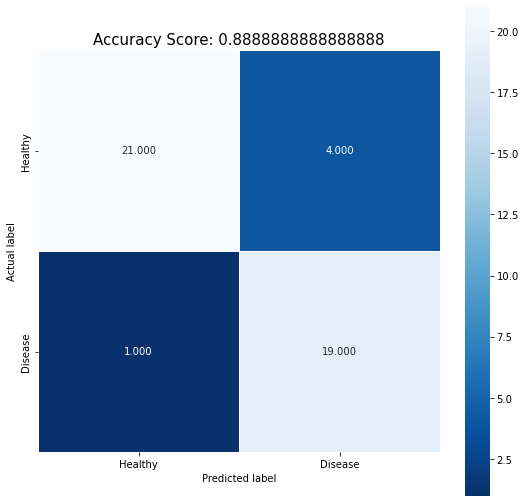

In [17]:
lasso = Lasso(alpha=0.01).fit(data_train_new, (data_train['Cancer type'] != 'Normal').astype(float))

val_preds = lasso.predict(data_validation_new)

threshold = 0.36 #different thresholds tested to see which work best
total = len(val_preds)
correct = 0
for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
  #print(a, b)
  option1 = (a < threshold) and (b == 0)
  option2 = (a >= threshold) and (b == 1)
  #print(option1 or option2)
  if option1 or option2:
    correct += 1
nvp = val_preds >= threshold
cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), nvp)

print(correct / total)

shanko_metrics(cm, correct/total)

In [78]:
max(best_params.values())

0.8888888888888888

0.8222222222222222


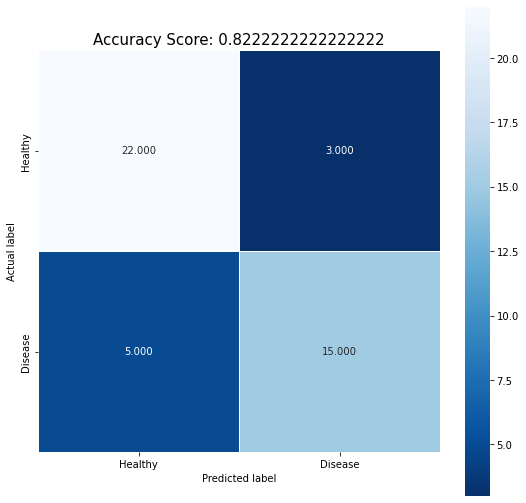

In [20]:
reg = LogisticRegression().fit(data_train_new, (data_train['Cancer type'] != 'Normal').astype(float))

val_preds = reg.predict(data_validation_new)
#print(val_preds)
#print((data_validation['Cancer type'] != 'Normal').astype(float))

# 1 = disease
# 0 = healthy

total = len(val_preds)
correct = 0
for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
  if a == b:
    correct += 1

print(correct / total)

cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), val_preds)

shanko_metrics(cm, correct/total)

# Using Original Data Filtered by PCA Results

In [ ]:
cols_needed = ['Unnamed: 0', 'Biosample type', 'Biosample name', 'Tissue type', 'Cancer type', 'Region number']
key_bins = ['125955', '123912', '269320', '272922', '98843', '129054', '260129', '8226', '288802', '266280', '79921', '44083', '233011', '18485', '48195', '282195', '79956', '219770', '219771', '219772', '265852', '40059', '88188', '175753', '78999', '24728', '129687', '68766', '68767', '194208', '303774', '230563', '65193', '181434', '34495', '305866', '99532', '88273', '139474', '305879', '46313', '2795', '133356', '274160', '285943', '87799', '196354', '212738', '83720', '16141', '16143', '139538', '165661', '250156', '48943', '152380', '240958', '106304', '200028', '31591', '96110', '258421', '108413', '287619', '280981', '33689', '33697', '250791', '139178', '257965', '92082', '123314', '247738', '34758', '11728', '25047', '253439']
kbi = [int(item) for item in key_bins]
kbi.sort()
print(kbi)
key_bins = [str(item) for item in kbi]
cols_needed.extend(key_bins)

fulldf = pd.read_csv('accessibilty-percents-10000-bin.csv', index_col=0, usecols=cols_needed)
all_data = fulldf
all_data.head()

[2795, 8226, 11728, 16141, 16143, 18485, 24728, 25047, 31591, 33689, 33697, 34495, 34758, 40059, 44083, 46313, 48195, 48943, 65193, 68766, 68767, 78999, 79921, 79956, 83720, 87799, 88188, 88273, 92082, 96110, 98843, 99532, 106304, 108413, 123314, 123912, 125955, 129054, 129687, 133356, 139178, 139474, 139538, 152380, 165661, 175753, 181434, 194208, 196354, 200028, 212738, 219770, 219771, 219772, 230563, 233011, 240958, 247738, 250156, 250791, 253439, 257965, 258421, 260129, 265852, 266280, 269320, 272922, 274160, 280981, 282195, 285943, 287619, 288802, 303774, 305866, 305879]


,Biosample type,Biosample name,Tissue type,Cancer type,Region number,2795,8226,11728,16141,16143,...,272922,274160,280981,282195,285943,287619,288802,303774,305866,305879
Sample_0025,Primary Cell,CD56Bright natural killer cell,Blood,Normal,48025,0.3296,0.0,0.1137,0.1930,0.1931,...,0.1968,0.0854,0.3967,0.0000,0.1573,0.2230,0.1122,0.0000,0.0000,0.0000
Sample_0026,Primary Cell,CD56Bright natural killer cell,Blood,Normal,50447,0.2716,0.0,0.1119,0.1886,0.2083,...,0.1553,0.0510,0.3694,0.0492,0.1211,0.2378,0.0780,0.0000,0.4132,0.4175
Sample_0027,Primary Cell,CD56Bright natural killer cell,Blood,Normal,47349,0.2054,0.0,0.0998,0.0730,0.0000,...,0.1906,0.0000,0.2684,0.0000,0.0124,0.0856,0.0463,0.6411,0.2242,0.1836
Sample_0028,Primary Cell,CD56Bright natural killer cell,Blood,Normal,46698,0.1332,0.0,0.0955,0.0336,0.0000,...,0.1782,0.0000,0.3470,0.0000,0.0190,0.0516,0.0591,0.3899,0.6777,0.5182
Sample_0029,Primary Cell,CD56Dim natural killer cell,Blood,Normal,40745,0.3013,0.0,0.0619,0.1342,0.1442,...,0.1614,0.1334,0.2754,0.0000,0.0000,0.0762,0.0829,0.1243,0.0000,0.0000


In [33]:
# In the first step we will split the data in training and remaining dataset
data_train, data_rem = train_test_split(all_data, train_size=0.8, random_state=543)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
data_validation, data_test = train_test_split(data_rem, test_size=0.5, random_state=82)

print(type(data_train))
print(data_train.shape)
print(data_validation.shape)
print(data_test.shape)

<class 'pandas.core.frame.DataFrame'>
(361, 82)
(45, 82)
(46, 82)


In [34]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn import metrics
def shanko_metrics(cm, acc):
  cm = pd.DataFrame(cm, index=['Healthy', 'Disease'], columns=['Healthy', 'Disease'])

  import matplotlib.pyplot as plt
  import seaborn as sns

  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(acc)
  plt.title(all_sample_title, size = 15);

In [35]:
#data_train = data_train.iloc[:,5:]
#data_test = data_test.iloc[:,5:]
#data_validation = data_validation.iloc[:,5:]
#print(data_train)
max_accuracy = 0
param=0
for i in range(1,101):
    reg = LinearRegression().fit(data_train.iloc[:,5:], (data_train['Cancer type'] != 'Normal').astype(float))

    val_preds = reg.predict(data_validation.iloc[:,5:])
    #print(val_preds)
    #print((data_validation['Cancer type'] != 'Normal').astype(float))

    threshold = i/100
    total = len(val_preds)
    correct = 0
    for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
      #print(a, b)
      option1 = (a < threshold) and (b == 0)
      option2 = (a >= threshold) and (b == 1)
      #print(option1 or option2)
      if option1 or option2:
        correct += 1


    #print(correct / total)
    if(correct/total>max_accuracy):
        max_accuracy=correct/total
        param=i/100
print(max_accuracy)
print(param)

    #nvp = val_preds >= threshold
    #cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), nvp)

    #shanko_metrics(cm, correct/total)

0.8888888888888888
0.3


0.8888888888888888


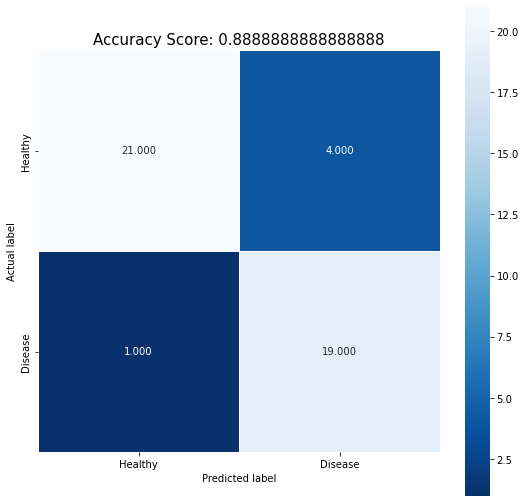

In [36]:
reg = LinearRegression().fit(data_train.iloc[:,5:], (data_train['Cancer type'] != 'Normal').astype(float))

val_preds = reg.predict(data_validation.iloc[:,5:])
#print(val_preds)
#print((data_validation['Cancer type'] != 'Normal').astype(float))

threshold = 0.3
total = len(val_preds)
correct = 0
for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
  #print(a, b)
  option1 = (a < threshold) and (b == 0)
  option2 = (a >= threshold) and (b == 1)
  #print(option1 or option2)
  if option1 or option2:
    correct += 1


print(correct / total)
nvp = val_preds >= threshold
cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), nvp)

shanko_metrics(cm, correct/total)

In [48]:
#data_train = data_train.iloc[:,5:]
#data_test = data_test.iloc[:,5:]
#data_validation = data_validation.iloc[:,5:]
#print(data_train)
max_accuracy = 0
al = 1
thres=1
equivalent_params=[]
for i in range(1,101):
    for j in range(1,101):
        ridge = Ridge(alpha=i/100).fit(data_train.iloc[:,5:], (data_train['Cancer type'] != 'Normal').astype(float))

        val_preds = ridge.predict(data_validation.iloc[:,5:])
        #print(val_preds)
        #print((data_validation['Cancer type'] != 'Normal').astype(float))

        threshold = j/100
        total = len(val_preds)
        correct = 0
        for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
          #print(a, b)
          option1 = (a < threshold) and (b == 0)
          option2 = (a >= threshold) and (b == 1)
          #print(option1 or option2)
          if option1 or option2:
            correct += 1


        #print(correct / total)
        if(correct/total>max_accuracy):
            max_accuracy=correct/total
            al=i/100
            thres = j/100
            equivalent_params=[]
        elif(correct/total==max_accuracy):
            equivalent_params.append((i/100,j/100))
print(max_accuracy)
print(al)
print(thres)
#print(equivalent_params)

    #nvp = val_preds >= threshold
    #cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), nvp)

    #shanko_metrics(cm, correct/total)

0.8888888888888888
0.01
0.3


0.8888888888888888


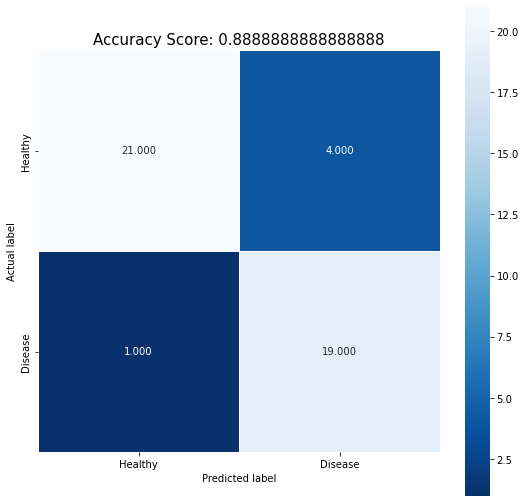

In [51]:
ridge = Ridge(alpha=.01).fit(data_train.iloc[:,5:], (data_train['Cancer type'] != 'Normal').astype(float))

val_preds = ridge.predict(data_validation.iloc[:,5:])
#print(val_preds)
#print((data_validation['Cancer type'] != 'Normal').astype(float))

threshold = 0.3
total = len(val_preds)
correct = 0
for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
  #print(a, b)
  option1 = (a < threshold) and (b == 0)
  option2 = (a >= threshold) and (b == 1)
  #print(option1 or option2)
  if option1 or option2:
    correct += 1


print(correct / total)
nvp = val_preds >= threshold
cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), nvp)

shanko_metrics(cm, correct/total)

In [52]:
#data_train = data_train.iloc[:,5:]
#data_test = data_test.iloc[:,5:]
#data_validation = data_validation.iloc[:,5:]
#print(data_train)
max_accuracy = 0
al = 1
thres=1
equivalent_params=[]
for i in range(1,101):
    for j in range(1,101):
        lasso = Lasso(alpha=i/100).fit(data_train.iloc[:,5:], (data_train['Cancer type'] != 'Normal').astype(float))

        val_preds = lasso.predict(data_validation.iloc[:,5:])
        #print(val_preds)
        #print((data_validation['Cancer type'] != 'Normal').astype(float))

        threshold = j/100
        total = len(val_preds)
        correct = 0
        for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
          #print(a, b)
          option1 = (a < threshold) and (b == 0)
          option2 = (a >= threshold) and (b == 1)
          #print(option1 or option2)
          if option1 or option2:
            correct += 1


        #print(correct / total)
        if(correct/total>max_accuracy):
            max_accuracy=correct/total
            al=i/100
            thres = j/100
            equivalent_params=[]
        elif(correct/total==max_accuracy):
            equivalent_params.append((i/100,j/100))
print(max_accuracy)
print(al)
print(thres)
#print(equivalent_params)

    #nvp = val_preds >= threshold
    #cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), nvp)

    #shanko_metrics(cm, correct/total)

0.7777777777777778
0.01
0.28


0.7777777777777778


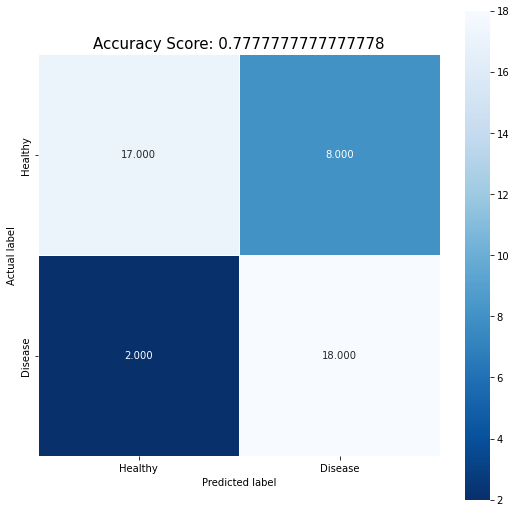

In [53]:
lasso = Lasso(alpha=.01).fit(data_train.iloc[:,5:], (data_train['Cancer type'] != 'Normal').astype(float))

val_preds = lasso.predict(data_validation.iloc[:,5:])
#print(val_preds)
#print((data_validation['Cancer type'] != 'Normal').astype(float))

threshold = 0.28
total = len(val_preds)
correct = 0
for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
  #print(a, b)
  option1 = (a < threshold) and (b == 0)
  option2 = (a >= threshold) and (b == 1)
  #print(option1 or option2)
  if option1 or option2:
    correct += 1


print(correct / total)
nvp = val_preds >= threshold
cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), nvp)

shanko_metrics(cm, correct/total)

0.8666666666666667


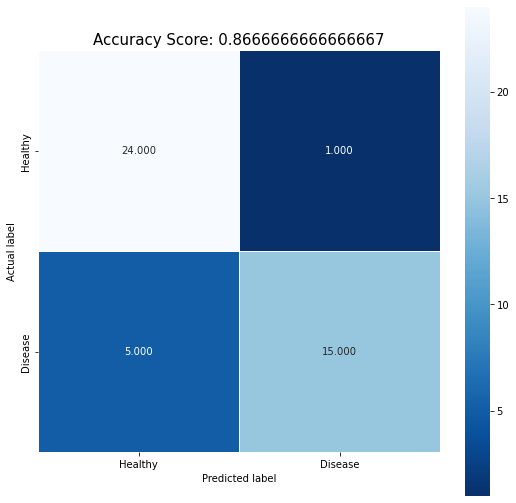

In [54]:
log = LogisticRegression().fit(data_train.iloc[:,5:], (data_train['Cancer type'] != 'Normal').astype(float))

val_preds = log.predict(data_validation.iloc[:,5:])
#print(val_preds)
#print((data_validation['Cancer type'] != 'Normal').astype(float))

# 1 = disease
# 0 = healthy

total = len(val_preds)
correct = 0
for a, b in zip(val_preds, (data_validation['Cancer type'] != 'Normal').astype(float)):
  if a == b:
    correct += 1

print(correct / total)

cm = metrics.confusion_matrix((data_validation['Cancer type'] != 'Normal').astype(float), val_preds)

shanko_metrics(cm, correct/total)